### Analyzing the Time Series pattern in Subway ridership data

For this analysis, we use the datewise cumulative number of passengers entring into MTAsubway systems.
The data was obtained from http://web.mta.info/developers/turnstile.html
For ease of convenience, the original turnstile data was preprocessed and stored in a remote location at github
such that the final useful data can be accessed without downloading it from the developer website everytime. 

In [11]:
# Import useful packages

from __future__  import print_function, division # for setting up compatibility between python2.0 and python3.0
import pandas as pd # for handling data frames
import numpy as np # for handling numbers and arrays
import matplotlib.pylab as plt # for drwaing plots
import os # for running terminal commands
import urllib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import matplotlib.gridspec as gridspec
%matplotlib inline


In [12]:
# Check if PUIDATA is present or not and if not set it up
if os.getenv("PUIDATA")==None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    print("Earlier missing now, updated:  PUIdata:", os.getenv("PUIDATA"))
else:
    print("Already present: PUIdata", os.getenv("PUIDATA"))

Already present: PUIdata /nfshome/skp454/PUIdata


In [13]:
# Download csv from github account
os.system("curl -O https://raw.githubusercontent.com/Shivam0712/PUI2018_skp454/master/HW8_skp454/DaywiseEntries.csv")
os.system("mv DaywiseEntries.csv " + os.getenv("PUIDATA"))

0

In [14]:
# Import and treat data for datewise number of passenger entring into subway system 
df_daywise = pd.read_csv(os.getenv("PUIDATA") + "/DaywiseEntries.csv", usecols=['DATE','ENTRIES'])
df_daywise['DATE']=df_daywise['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
df_daywise = df_daywise.sort_values(['DATE'])
df_daywise = df_daywise.reset_index(drop= True)

In [15]:
# Calculate the yearly trend for each date by calculating the moving average of last 365 days
for i in range(364,len(df_daywise)):
    df_daywise.loc[i,'YEARLY_TREND']= np.sum(df_daywise.ENTRIES[i-364:i])/364

In [16]:
# Calculate the residual after deducting trend from number of entries
df_daywiseTr=df_daywise.loc[364:797,:].reset_index(drop=True)
df_daywiseTr['TREND_RESIDUAL']=df_daywiseTr['ENTRIES']-df_daywiseTr['YEARLY_TREND']

In [17]:
# Calculate the moving weekly average trend  
for i in range(36,len(df_daywiseTr)):
    df_daywiseTr.loc[i,'WEEKS_TREND']= np.sum(df_daywiseTr.TREND_RESIDUAL[i-7:i])/7

In [18]:
# Calculate the residual after deducting weekly moving average from residual left after deducting trend
df_daywiseTrSea=df_daywiseTr.loc[36:,:].reset_index(drop=True)
df_daywiseTrSea['WEEKS_TREND_RESIDUAL']=df_daywiseTrSea['TREND_RESIDUAL']-df_daywiseTrSea['WEEKS_TREND']
df_daywiseTrSea['MODELLED_DATA'] = df_daywiseTrSea['YEARLY_TREND']+df_daywiseTrSea['WEEKS_TREND']
df_daywiseDup=df_daywiseTrSea.copy(deep =True)
df_daywiseDup.index = df_daywiseDup['DATE']

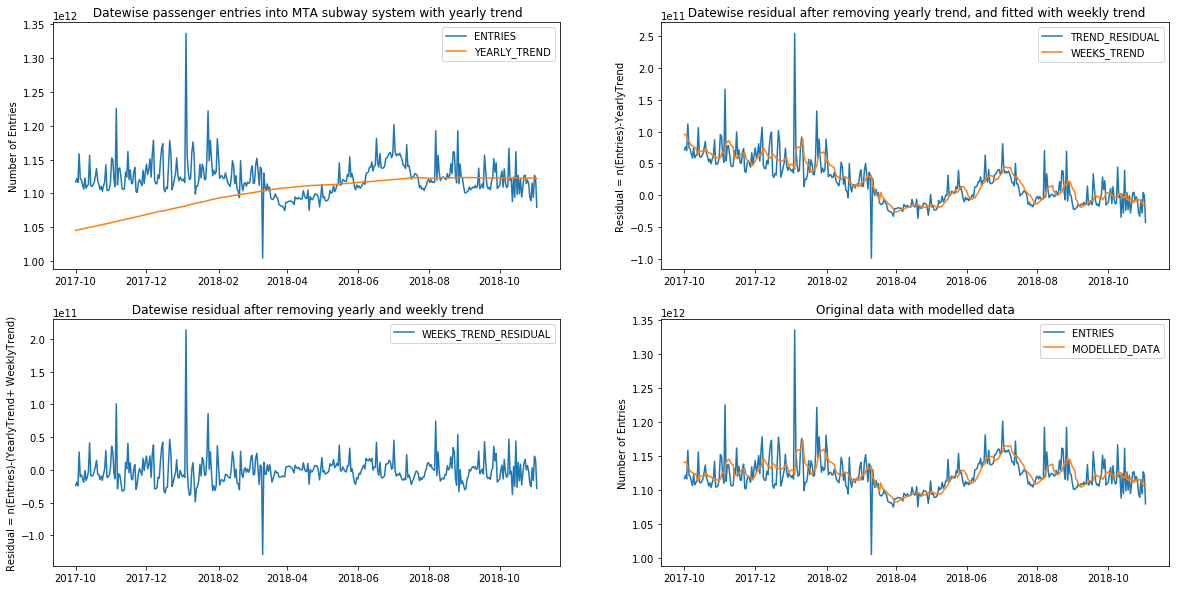

In [19]:
# Plot the data

plt.figure(figsize=(20, 10))


#plt.subplot(423)
plt.subplot(221)
plt.plot(df_daywiseDup['ENTRIES'], '-')
ax = plt.plot(df_daywiseDup['YEARLY_TREND'], '-')
plt.ylabel("Number of Entries")
plt.title(" Datewise passenger entries into MTA subway system with yearly trend")
plt.legend()
#plt.show()

plt.subplot(222)
plt.plot(df_daywiseDup['TREND_RESIDUAL'], '-')
ax = plt.plot(df_daywiseDup['WEEKS_TREND'], '-')
plt.ylabel("Residual = n(Entries)-YearlyTrend")
plt.title(" Datewise residual after removing yearly trend, and fitted with weekly trend")
plt.legend()
#plt.show()


plt.subplot(223)
plt.plot(df_daywiseDup['WEEKS_TREND_RESIDUAL'], '-')
#ax = plt.plot(df_daywiseDup['4_WEEKS_TREND'], '-')
plt.ylabel("Residual = n(Entries)-(YearlyTrend+ WeeklyTrend)")
plt.title(" Datewise residual after removing yearly and weekly trend")
plt.legend()
#plt.show()

plt.subplot(224)
plt.plot(df_daywiseDup['ENTRIES'], '-')
ax = plt.plot(df_daywiseDup['MODELLED_DATA'], '-')
plt.ylabel("Number of Entries")
plt.title("Original data with modelled data")
plt.legend()

plt.show()

### Fig1: Time series data of passengers' entries into MTA Subway

1. In the top left figure we see the original data of number of entries over time. This data has many repetative cycles in it alongwith some trend.

2. In top right figure we remove the yearly trend and the pattern stabilizes a bit. The weekly trend is fit over this data by taking average of last 7 days.

3. After removing the yearly and wekly trend, in bottom left figure we see the pattern completely stabilizes and represents the pattern of a white noise.

4. In bottom right figure when we superimpose our modelled data which is obtained by adding yearly and weekly trend for each day, we see the model data is able to explain much of the variation present in the actual data.


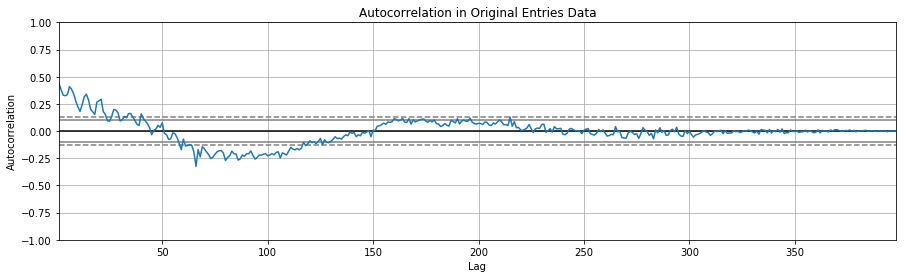

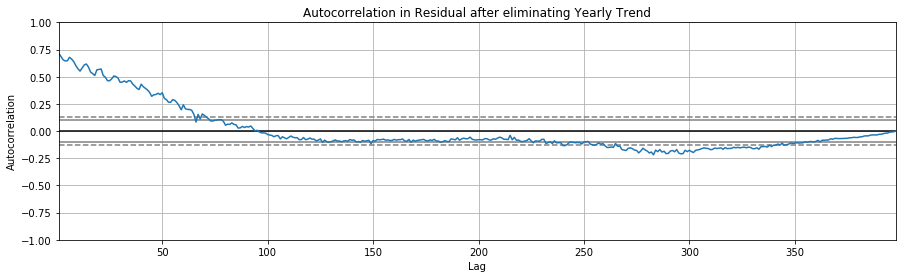

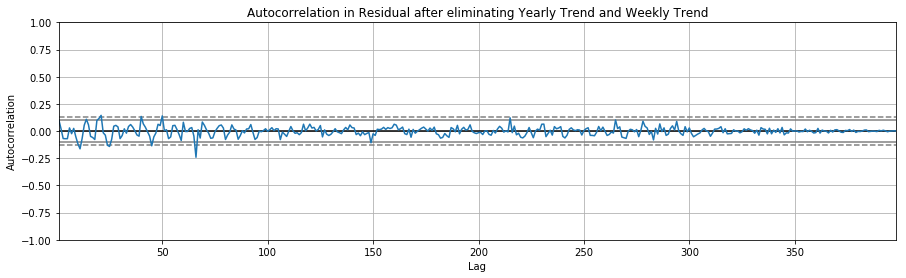

In [20]:
# plot the autocorrelation

figure = plt.figure(figsize=(15, 4))
autocorrelation_plot(df_daywiseDup['ENTRIES'])
plt.title("Autocorrelation in Original Entries Data")
plt.show()

figure = plt.figure(figsize=(15, 4))
autocorrelation_plot(df_daywiseDup['TREND_RESIDUAL'])
plt.title("Autocorrelation in Residual after eliminating Yearly Trend")
plt.show()

figure = plt.figure(figsize=(15, 4))
autocorrelation_plot(df_daywiseDup['WEEKS_TREND_RESIDUAL'])
plt.title("Autocorrelation in Residual after eliminating Yearly Trend and Weekly Trend")
plt.show()


### Fig2: Autocorrelation in Time Series data of Subway Entries

1. In the top figure we can see, in the original data for datewise entries, autocorrelation exist for both short and long periods of lag.

2. In the middle figure we can see, after removing the yealy trend, in the residual data, although the autocorrelation increased for short period of lags, the correlation for long period of lags were eliminated.

3. In the bottom figure we can see, after removing the yearly and weekly trend from the original data, the residual left is not autocorrelated to each other thus, the residual can be treated as white noise or stationary data 

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
df_daywiseDup=df_daywiseTrSea.copy(deep =True)
df_daywiseDup.index = df_daywiseDup['DATE']

In [23]:
df_daywiseDup.head()

,DATE,ENTRIES,YEARLY_TREND,TREND_RESIDUAL,WEEKS_TREND,WEEKS_TREND_RESIDUAL,MODELLED_DATA
DATE,,,,,,,
2017-10-01,2017-10-01,1116829506030,1.045466e+12,7.136348e+10,9.538760e+10,-2.402412e+10,1.140854e+12
2017-10-02,2017-10-02,1121664792880,1.045821e+12,7.584351e+10,9.471981e+10,-1.887631e+10,1.140541e+12
2017-10-03,2017-10-03,1116169740929,1.046146e+12,7.002340e+10,9.460082e+10,-2.457741e+10,1.140747e+12
2017-10-04,2017-10-04,1158436297311,1.046528e+12,1.119084e+11,8.464980e+10,2.725856e+10,1.131178e+12
2017-10-05,2017-10-05,1121419122859,1.046993e+12,7.442605e+10,8.498854e+10,-1.056249e+10,1.131982e+12


In [26]:
 #Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_daywiseDup['WEEKS_TREND_RESIDUAL'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.301291e+00
p-value                        4.011875e-13
#Lags Used                     1.000000e+01
Number of Observations Used    3.870000e+02
Critical Value (10%)          -2.570764e+00
Critical Value (5%)           -2.869037e+00
Critical Value (1%)           -3.447361e+00
dtype: float64


In [19]:
df_daywiseDup=df_daywise.copy(deep =True)
df_daywiseDup.index = df_daywiseDup['DATE']

In [21]:
df_daywiseDup['ENTRIES']

DATE
2016-08-27     967682360652
2016-08-28     963582991122
2016-08-29     975228478812
2016-08-30     970990913002
2016-08-31     959821903909
2016-09-01     990532758036
2016-09-02     982991480256
2016-09-03     962696878900
2016-09-04     959867714522
2016-09-05     961733923763
2016-09-06    1011576961943
2016-09-07     989060398761
2016-09-08    1034919086682
2016-09-09    1002741294064
2016-09-10     967445607671
2016-09-11     969417000485
2016-09-12     986509217838
2016-09-13     971163327131
2016-09-14     959786444766
2016-09-15     958745230331
2016-09-16    1000751648970
2016-09-17     980464391239
2016-09-18     984416823550
2016-09-19     989722217520
2016-09-20     998371923273
2016-09-21    1025293550142
2016-09-22     986465272100
2016-09-23     982748809615
2016-09-24     986141022900
2016-09-25     984875068942
                  ...      
2018-10-04    1109146427606
2018-10-05    1135907428557
2018-10-06    1115840287714
2018-10-07    1108682588297
2018-10-08    1

In [1]:
from google.transit import gtfs_realtime_pb2
import requests

feed = gtfs_realtime_pb2.FeedMessage()
response = requests.get('URL OF YOUR GTFS-REALTIME SOURCE GOES HERE')
feed.ParseFromString(response.content)
for entity in feed.entity:
  if entity.HasField('trip_update'):
    print(entity.trip_update)

ImportError: No module named 'google'

In [3]:
['A','B','C','D']+['A','F','G']

['A', 'B', 'C', 'D', 'A', 'F', 'G']